In [ ]:
import yaml
import re
import enum
from pprint import pprint, pformat
from tabulate import tabulate
import itertools
import random
import math
import time

from dataclasses import dataclass
from typing import List, Tuple, Set
from copy import copy, deepcopy

def parse_spec(file_path):
  with open(file_path, 'r') as file_handle:
    spec = yaml.safe_load(file_handle)
  return spec

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx

In [4]:
ex_spec = parse_spec('video-editor.yaml')

## Comparing Objects

In [5]:
# TODO: refactor to use listable instead of this function
def process_listable(target, func):
  if target is None:
    return

  if type(target) == list:
    for target_item in target:
      func(target_item)
  else:
    func(target)

# Return a list even if it's a single thing, so you can always loop through it
def listable(content):
  if type(content) is str:
    return [content]
  elif type(content) is list:
    return content
  elif content is None:
    return []
  else:
    print('Listable item is of type:', type(content))
    assert(False)

def strip_type(obj):
  return re.sub(r'\((\w|-)*\) ', '', obj)


In [ ]:
# NOTE: This is mostly used as a parser to get all of the objects. It was previously used to do more stuff, but it's not
# really worth the refactor right now.
class ObjectRegistry(object):
  # obj mapto obj registry
  # {obj name: set(obj names)}
  registry: dict[str, Set[str]] = {}
  
  # # registry for structures between structures, repr, etc.
  # # {obj name: set((entity-name, connection-type), etc...) }
  # connections: dict[str, Set[Tuple[str, str]]] = {}

  def __init__(self, spec=None):
    self.registry = {}
    if spec is not None:
      self.register_spec_objects(spec)

  def __str__(self):
    return pformat(self.registry)

  def register_object(self, obj):
    # -> means mapto
    # . means subset
    # / means component  # TODO: actually do this!!
    assert(type(obj) is str)
    obj = strip_type(obj)

    arrow_array = obj.split('->')
    for arrow_idx, arrow_term in enumerate(arrow_array):
      
      dot_array = arrow_term.split('.')
      for dot_idx, dot_term in enumerate(dot_array):
        subject = '.'.join(dot_array[:dot_idx + 1]) # join up to idx
        if not self.registry.get(subject):
          self.registry[subject] = set()
        
        if dot_idx > 0:
          # every sequence maps to the previous element eg. a.b.c => {a.b.c: {a.b}, a.b: {a}}
          previous = '.'.join(dot_array[:dot_idx])
          self.registry[subject].add(previous)
      
      if arrow_idx > 0:
        # a pair of arrows lhs->rhs => {lhs: {rhs}}
        lhs = self.registry[arrow_array[arrow_idx - 1]]
        rhs = arrow_array[arrow_idx]
        lhs.add(rhs)

  def register_struct_objects(self, struct, process_func):
    if struct.get('type') == 'group':
      # Groups also behave as objects, so register them
      name = struct.get('name')
      if name is None:
        print('Warning! No name provided for group. Using `NO NAME PROVIDED` instead. TODO: generate ID.')
        name = 'NO NAME PROVIDED'

      if self.registry.get(name) is None:
        self.registry[name] = set()
      
      # TODO: do groups map to their elements? Really, does the transitive property apply? My hunch is no, but need to think more

    process_listable(struct.get('affects'), process_func)
    process_listable(struct.get('covered-by'), process_func)
    # TODO: relate all of the objects affected/covered by a structure. 

    for derivative in struct.get('structures', []):
      self.register_struct_objects(derivative, process_func=process_func)

  def register_repr_objects(self, repr, process_func):
    repr_type = repr.get('type', '')
    # print(repr_type)
    for repr_item in repr.get('objects', []):
      assert(type(repr_item) is dict)
      assert(len(list(repr_item.keys())) == 1)
      repr_obj = list(repr_item.keys())[0]


      if type(repr_item[repr_obj]) is str:
        # turn str into list to iterate through it properly
        repr_item[repr_obj] = [repr_item[repr_obj]]

      # assert(len(repr_item.values()) == 1)
      # repr_obj, target_objs = list(repr_item.items())[0]
      for target_obj in repr_item[repr_obj]:
        process_func(target_obj)
        # Map every item to the associated representational object
        # eg. {message: {textbox}, author: {textbox}}
        if self.registry.get(target_obj) is None:
          self.registry[target_obj] = set()
        self.registry[target_obj].add(repr_obj)
        # objects[target].add(repr_type + '/' + repr_obj)  # when we prefix the core stuff
        # note: this is a bit backwards compared to the syntax!


  def register_spec_objects(self, spec): # {object: [mapto-targets]}
    def register_object_here(target):
      self.register_object(target)
    
    process_listable(spec.get('objects'), register_object_here)
    # TODO: deal with `objects` block

    for struct in spec.get('structures', []):
      self.register_struct_objects(struct, register_object_here)
      
    for repr in spec.get('representations', []):
      self.register_repr_objects(repr, register_object_here)


In [7]:
# Test in Object Registry
print('testing: a')
test = ObjectRegistry()
print('expected:')
pprint({'a': set()})
print('got:')
test.register_object('a')
print(test)

print()

print('testing: a.b.c')
print('expected:')
pprint({'a': set(), 'a.b': {'a'}, 'a.b.c': {'a.b'}})
print('got:')
test = ObjectRegistry()
test.register_object('a.b.c')
print(test)

print()

print('testing: a->b->c')
print('expected:')
pprint({'a': {'b'}, 'b': {'c'}, 'c': set()})

print('got:')
test = ObjectRegistry()
test.register_object('a->b->c')
print(test)

print()

print('testing: a.b->x->z.w')
print('expected:')
print({'a': set(), 'a.b': {'x', 'a'}, 'x': {'z.w'}, 'z': set(), 'z.w': {'z'}})

print('got:')
test = ObjectRegistry()
test.register_object('a.b->x->z.w')
print(test)

testing: a
expected:
{'a': set()}
got:
{'a': set()}

testing: a.b.c
expected:
{'a': set(), 'a.b': {'a'}, 'a.b.c': {'a.b'}}
got:
{'a': set(), 'a.b': {'a'}, 'a.b.c': {'a.b'}}

testing: a->b->c
expected:
{'a': {'b'}, 'b': {'c'}, 'c': set()}
got:
{'a': {'b'}, 'b': {'c'}, 'c': set()}

testing: a.b->x->z.w
expected:
{'a': set(), 'a.b': {'a', 'x'}, 'x': {'z.w'}, 'z': set(), 'z.w': {'z'}}
got:
{'a': set(), 'a.b': {'a', 'x'}, 'x': {'z.w'}, 'z': set(), 'z.w': {'z'}}


In [8]:
print('testing: days.selected->events')
print('expected:')
pprint({'days.selected': {'events', 'days'}, 'days': set(), 'events': set()})

print('got:')
test = ObjectRegistry()

test.register_object('days.selected->events')
print(test)

testing: days.selected->events
expected:
{'days': set(), 'days.selected': {'days', 'events'}, 'events': set()}
got:
{'days': set(), 'days.selected': {'days', 'events'}, 'events': set()}


In [9]:
ex_obj_registry = ObjectRegistry()
ex_obj_registry.register_spec_objects(ex_spec)
print(ex_obj_registry)

{'playhead': {'vlines', 'videos.in-editor/images'},
 'playhead->videos.in-editor/images': {'rects'},
 'timestamps': {'vlines'},
 'tracks': {'regions'},
 'videos': set(),
 'videos.in-editor': {'videos', 'rects'},
 'videos.in-editor/images': {'videos'},
 'videos/first-frame': {'regions'}}


In [10]:
core_spec = parse_spec('core.yaml')
core_objs = ObjectRegistry()

# TODO: probably need to consider prefixing gui on these
for repr_type in core_spec.get('representation-types', []):
  # print(repr_type['name'])
  core_objs.register_spec_objects(repr_type)

# register_spec_objects(core_spec, core_objs)
print(core_objs)

{'hlines': {'lines'},
 'icons': {'regions'},
 'lines': {'regions'},
 'points': set(),
 'rects': {'regions'},
 'regions': set(),
 'vlines': {'lines'}}


In [ ]:
# NOTE: this is made redundant by the transitive closure of the graph
# NOTE: This is general! Assuming your relations/registry is shaped properly
# TODO: count depth
def get_node_join(left, right, relations, visited=set(), depth=0) -> str | None:
  assert(type(left) is str)
  assert(type(right) is str)
  
  if relations.get(left) is None or relations.get(right) is None:
    return None

  # Trace print
  # print(f"{left:<8} {right:<}")

  if left in visited or right in visited:
    # To avoid cycles, abort if we've already visited a node
    # NOTE: Not like 100% sure this is clean
    print("WARNING! Cycle detected in the relations.")
    return None

  if left == right:
    return left
  
  for next_left in relations[left]:
    left_res = get_node_join(next_left, right, relations, visited=visited)
    if left_res is None:
      # When you reach the leaf of a spanning tree, pop back up to recurse
      for next_right in relations[right]:
        return get_node_join(left, next_right, relations, visited=visited)
    else:
      return left_res

  if len(relations[right]) == 0 and len(relations[left]) == 0:
    return None

print()
print('vlines, hlines => ' + str(get_node_join('vlines', 'hlines', core_objs.registry)))
print('rects, hlines => ' + str(get_node_join('rects', 'hlines', core_objs.registry)))
print('points, hlines => ' + str(get_node_join('points', 'hlines', core_objs.registry)))


vlines, hlines => lines
rects, hlines => regions
points, hlines => None


## Comparing Structures
- need to show that two structures are "the same" based on their types
- do structures map to other structures

In [12]:
class StructRegistry(object):
  # Keep track of the type of each structure
  # TODO: I guess you only ever have the one type huh? keeping it a set for now
  # so that I can use get_node_join() without changing it.
  typeRegistry: dict[str, Set[str]] = {}

  # Keep track of which structure maps to which
  mapRegistry: dict[str, Set[str]] = {}

  def __init__(self, spec=None, core_spec=None):
    self.typeRegistry = {}
    self.mapRegistry = {}
    if spec is not None:
      self.register_spec(spec)
    
    if core_spec is None:
      # HACK: this probably shouldn't be hard-coded
      self.core_spec = parse_spec('core.yaml')
  
  def _prefix(parents: List[str]):
    return '/'.join(parents) + '/'

  def register_struct(self, struct, parents=None):
    name = struct.get('name')
    assert(name is not None)

    # TODO: do prefixes for structure components
    prefix = '' if parents is None else self._prefix(parents)

    # Register type
    if self.typeRegistry.get(name) is None:
      self.typeRegistry[name] = set()
    
    if struct_type := struct.get('type'):
      self.typeRegistry[name].add(struct_type) 

    # Register map
    if self.mapRegistry.get(name) is None:
      self.mapRegistry[name] = set()
    
    if struct_maps := struct.get('mapto'):
      def process_struct_map(target):
        self.mapRegistry[name].add(target)
      
      process_listable(struct_maps, process_struct_map)
    
    # Registrer connections for objects
    # TODO
  
  def register_spec(self, spec, parents=None):
    for struct_type in core_spec.get('structure-types', []):
      self.register_struct_type(struct_type)

    for struct in spec.get('structures', []):
      self.register_struct(struct, parents)
  
  def register_struct_type(self, struct_type):
    # TODO: not 100% sure about how the semantics are being used (ie. type mapto is like a type for structure)
    name = struct_type.get('name')
    assert(name is not None)

    # Register type
    if self.typeRegistry.get(name) is None:
      self.typeRegistry[name] = set()
    
    # HACK: for the sake of comparing the type of structures from two different specs, it's easiest to think of
    # component-mapto as a type relation 
    if target := struct_type.get('mapto'):
      self.typeRegistry[name].add(target)
      
      

In [29]:
print(re.search("\(([\w-]+)\) (.*)", '(text) name->thing').groups())

('text', 'name->thing')


# Networkx Exploration
## Heuristic Metrics
We could try to prune possible matches using heuristics. Some metrics that come to mind:
- outgoing degree of nodes
- incoming degree of nodes (how many ancestors, fewer is better?)
- ???

How important is an object?  
- it maps to a bunch of stuff
- it has subsets
- it (or a subset) is represented

How important is a structure?
- it affects a bunch of stuff
- it has multiple covers

In [30]:
def draw_graph(graph, edge_relation):
  # Adapted from: https://stackoverflow.com/questions/20381460/how-to-draw-node-and-edge-attributes-in-a-networkx-graph
  # num_nodes = len(graph.nodes)
  # pos = nx.spring_layout(graph, k=4/(num_nodes**(0.5)), seed=0)  # Precompute positions (layout)
  # label_pos = {n: (x, y+0.15) for n, (x,y) in pos.items()}

  # This is a slightly nicer layout but super buggy
  pos = nx.kamada_kawai_layout(graph)  # Precompute positions (layout)
  label_pos = {n: (x, y+0.01) for n, (x,y) in pos.items()}

  # get edge and node attributes
  edge_labels = nx.get_edge_attributes(graph, edge_relation)
  node_states = nx.get_node_attributes(graph, edge_relation)

  # fig, ax = plt.plot()

  # draw graph
  nx.draw_networkx(graph, pos, with_labels=False)
  # draw node state labels
  nx.draw_networkx_labels(graph, label_pos, font_color='black')
  # draw edge attributes
  nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)

  # TODO: make offset labels fit
  # # adjust axes to fit offset labels
  # ax[1].set_ylim(tuple(i*1.1 for i in ax[1].get_ylim()))

  # plt.show()


DiGraph with 2 nodes and 1 edges
['hello', 'world']
[('hello', 'world')]
{('hello', 'world'): 'space'}


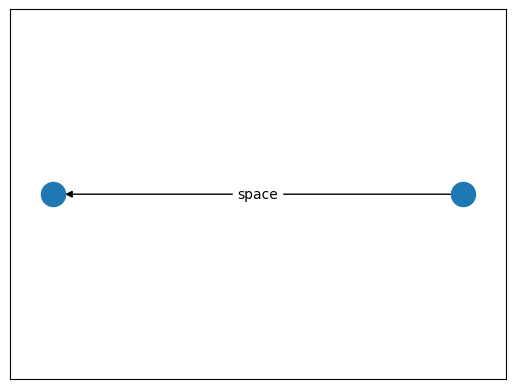

In [31]:
test_graph = nx.DiGraph()
test_graph.add_node('hello')
test_graph.add_node('hello')
test_graph.add_node('world')
test_graph.add_edge('hello', 'world', relation='space')
print(test_graph)
print(test_graph.nodes)
print(test_graph.edges)
print(nx.get_edge_attributes(test_graph, 'relation'))

# nx.draw(test_graph, with_labels=True)
draw_graph(test_graph, 'relation')

In [32]:
nx.kamada_kawai_layout(test_graph)

{'hello': array([1.00000000e+00, 4.37113883e-08]),
 'world': array([-1.00000000e+00, -4.37113883e-08])}

[1, 2, 3, 4]
[(1, 2), (2, 3), (2, 4)]

[1, 2, 3, 4]
[(1, 2), (1, 3), (1, 4), (2, 3), (2, 4)]
{(1, 2): 'a', (2, 3): 'b', (2, 4): 'c'}


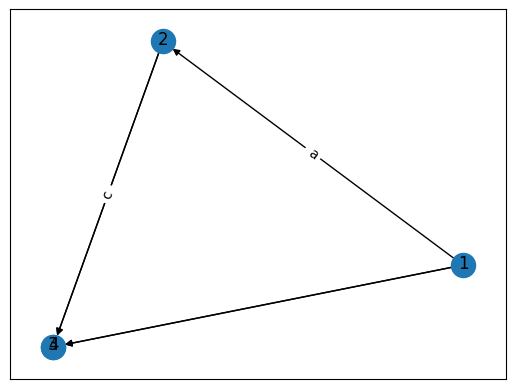

In [33]:
test_graph = nx.DiGraph()
test_graph.add_nodes_from([1,2,3,4])
test_graph.add_edges_from([(1,2, {'relation': 'a'}), (2,3, {'relation': 'b'}), (2, 4, {'relation': 'c'})])

print(test_graph.nodes)
print(test_graph.edges)

test_graph = nx.transitive_closure(test_graph, reflexive=False)
print()
print(test_graph.nodes)
print(test_graph.edges)
print(nx.get_edge_attributes(test_graph, 'relation'))

draw_graph(test_graph, 'relation')


[1, 2, 3, 4, 10, 20]
[(1, 2, 0), (1, 2, 1), (1, 10, 0), (2, 3, 0), (2, 20, 0), (3, 4, 0)]
{(1, 2, 0): 'a', (1, 2, 1): 'b', (1, 10, 0): 'b', (2, 3, 0): 'a', (2, 20, 0): 'b', (3, 4, 0): 'a'}


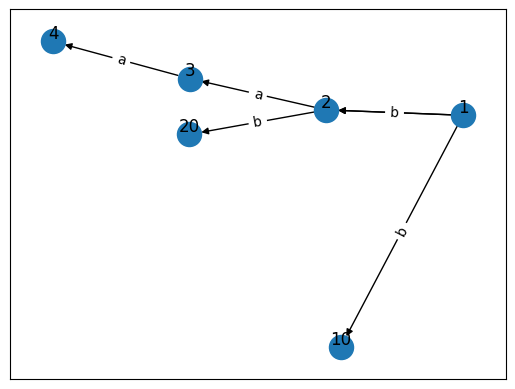

In [34]:
# NOTE: source need to be 
test_graph = nx.MultiDiGraph()
test_graph.add_nodes_from([1,2,3,4])
test_graph.add_edges_from([(1,2, {'rel': 'a'}), (2,3, {'rel': 'a'}), (3, 4, {'rel': 'a'})])

other_graph = nx.MultiDiGraph()
other_graph.add_nodes_from([1,2,3,10,20])
test_graph.add_edges_from([(1,2, {'rel': 'b'}), (1,10, {'rel': 'b'}), (2, 20, {'rel': 'b'})])

composed_graph = nx.compose(test_graph, other_graph)
print(composed_graph.nodes)
print(composed_graph.edges)
print(nx.get_edge_attributes(composed_graph, 'rel'))

draw_graph(composed_graph, 'rel')


-- mapto
videos.in-editor, videos, rects, playhead, vlines, timestamps, videos.in-editor/images, tracks, regions, playhead->videos.in-editor/images, videos/first-frame

videos.in-editor ~> videos
videos.in-editor ~> rects
playhead ~> vlines
playhead ~> timestamps
playhead ~> videos.in-editor/images
playhead ~> videos
timestamps ~> vlines
videos.in-editor/images ~> videos
tracks ~> regions
playhead->videos.in-editor/images ~> rects
videos/first-frame ~> regions

-- affects
editor-timeline, timestamps, vlines, playhead, videos.in-editor/images, videos, tracks, videos.in-editor, rects, alphabetical

editor-timeline ~> timestamps
editor-timeline ~> vlines
editor-timeline ~> playhead
editor-timeline ~> videos.in-editor/images
editor-timeline ~> videos
tracks ~> videos.in-editor
tracks ~> videos
tracks ~> rects
alphabetical ~> videos

-- covers
videos.in-editor, editor-timeline

videos.in-editor ~> editor-timeline



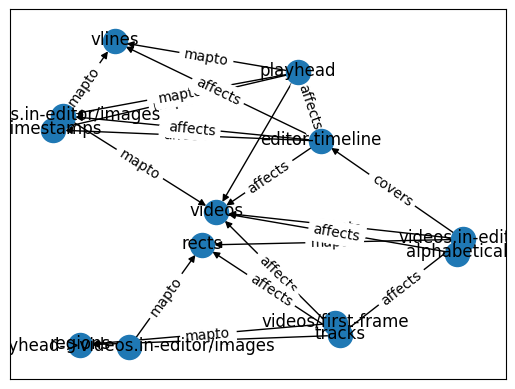

In [79]:
def make_spec_graphs(spec):
  graphs = {
    'mapto': nx.DiGraph(),
    'affects': nx.DiGraph(),
    'covers': nx.DiGraph()
  }

  obj_registry = ObjectRegistry(spec)
  
  for lhs, rhs_set in obj_registry.registry.items():
    # lhs = sanitize_name(lhs)
    for rhs in rhs_set:
      # rhs = sanitize_name(rhs)
      # Add mapto
      graphs['mapto'].add_nodes_from([lhs, rhs], ilk='object')
      graphs['mapto'].add_edge(lhs, rhs, rel='mapto')
  
  # Rule: Transitive closure on mapto
  graphs['mapto'] = nx.transitive_closure(graphs['mapto'])
  
  for obj in listable(spec.get('objects', [])):
    match = re.search("\(([\w-]+)\) (.*)", obj) # matches: (obj_type) obj_name
    if match is None:
      continue
    obj_type, obj_name = match.groups()
    obj_name = obj_name.split('->')[0].split('.')[0] 
    # prolog.append(f'type({obj_name}, {obj_type}).')
    # TODO: add type to a graph

  for struct in spec.get('structures', []):
    # struct_name = sanitize_name(struct.get('name', None))
    struct_name = struct.get('name', None)
    graphs['affects'].add_node(struct_name, ilk='structure')

    if struct_type := struct.get('type'):
      # prolog.append(f'type({struct_name}, {struct_type}).')
      pass

    for affected in listable(struct.get('affects', [])):
      # prolog.append(f'affects({struct_name}, {affected}).')
      graphs['affects'].add_node(affected, ilk='object')
      graphs['affects'].add_edge(struct_name, affected, rel='affects')
      
      # Rule: S affects A & A mapto B => S affects B
      if affected in graphs['mapto'].nodes:
        for knock_on_affected in graphs['mapto'].neighbors(affected):
          graphs['affects'].add_node(knock_on_affected, ilk='object')
          graphs['affects'].add_edge(struct_name, knock_on_affected, rel='affects')
    
    for cover in listable(struct.get('covered-by', [])):
      # prolog.append(f'covered_by({struct_name}, {cover}).')
      graphs['covers'].add_node(cover, ilk='object')
      graphs['covers'].add_node(struct_name, ilk='structure')
      graphs['covers'].add_edge(cover, struct_name, rel='covers')
  
  return graphs

def draw_graphs(graphs):
  combined_graph = nx.compose_all(graphs.values())
  draw_graph(combined_graph, 'rel')

def print_graphs(graphs):
  for relation, graph in graphs.items():
    print('\n--', relation)
    print(', '.join(graph.nodes))
    print()
    for edge in graph.edges:
      print(f'{edge[0]} ~> {edge[1]}')
  print()
    
graphs = make_spec_graphs(parse_spec('video-editor.yaml'))
print_graphs(graphs)
draw_graphs(graphs)

In [36]:
def heuristics(graphs):
  combined_graph = nx.compose_all(graphs.values())
  all_nodes = combined_graph.nodes
  node_neighbors = []

  # Outgoing Degree
  for node in all_nodes:
    total_degree = 0
    for rel, graph in graphs.items():
      if node in graph.nodes: 
        total_degree += len(list(nx.Graph(graph).neighbors(node)))
    node_neighbors.append((node, total_degree))
  
  print('-- Total of edges in & out of each nodes')
  for node, score in sorted(node_neighbors, key=lambda n: n[1], reverse=True):
    print(f'{node}: {score}')

graphs = make_spec_graphs(parse_spec('video-editor.yaml'))
heuristics(graphs)

-- Total of edges in & out of each nodes
videos: 6
editor-timeline: 6
videos.in-editor: 4
playhead: 4
tracks: 4
rects: 3
vlines: 3
videos.in-editor/images: 3
timestamps: 2
regions: 2
playhead->videos.in-editor/images: 1
videos/first-frame: 1
alphabetical: 1


In [ ]:
# print_graphs(graphs)
# graphs['affects'].nodes['time']

In [73]:
MAX_COST = 100
def node_match(n1, n2):
  print(n1, n2)
  if n1.get('ilk') is None or n2.get('ilk') is None:
    print('missing ilk')
    return False
  
  if n1.get('repr_obj', False) != n2.get('repr_obj', False):
    # don't match representation objects to non-representation objects
    return False
  
  return n1['ilk'] == n2['ilk']

def edge_match(e1, e2):
  if e1.get('rel') is None or e2.get('rel') is None:
    print('missing rel')
    return False
  return e1['rel'] == e2['rel']

def node_subst_cost(n1, n2):
  if n1.get('ilk') is None or n2.get('ilk') is None:
    print('missing ilk')
    return MAX_COST
  
  if n1.get('repr_obj', False) != n2.get('repr_obj', False):
    # don't match representation objects to non-representation objects
    return MAX_COST
  
  if n1['ilk'] != n2['ilk']:
    return MAX_COST
  else:
    return 0

def edge_subst_cost(e1, e2):
  if e1.get('rel') is None or e2.get('rel') is None:
    print('missing rel')
    return MAX_COST
  
  if e1['rel'] == e2['rel']:
    return 0
  else:
    return MAX_COST


In [39]:
print('---- as multiple graphs')
print_graphs(graphs)

print('\n---- as multi-graph')
composed_graph = nx.compose_all([nx.MultiDiGraph(graph) for graph in graphs.values()])
print(composed_graph.nodes)

for (lhs, rhs, rel) in composed_graph.edges.data('rel', default='None'):
  print(f'{rel}: {lhs} --> {rhs}')
  # print(f'{lhs} --{rel}--> {rhs}')

---- as multiple graphs

-- mapto
videos.in-editor, videos, rects, timestamps, vlines, playhead, videos.in-editor/images, tracks, regions, playhead->videos.in-editor/images, videos/first-frame

videos.in-editor ~> videos
videos.in-editor ~> rects
timestamps ~> vlines
playhead ~> vlines
playhead ~> videos.in-editor/images
playhead ~> videos
videos.in-editor/images ~> videos
tracks ~> regions
playhead->videos.in-editor/images ~> rects
videos/first-frame ~> regions

-- affects
editor-timeline, timestamps, vlines, playhead, videos.in-editor/images, videos, tracks, videos.in-editor, rects, alphabetical

editor-timeline ~> timestamps
editor-timeline ~> vlines
editor-timeline ~> playhead
editor-timeline ~> videos.in-editor/images
editor-timeline ~> videos
tracks ~> videos.in-editor
tracks ~> videos
tracks ~> rects
alphabetical ~> videos

-- covers
videos.in-editor, editor-timeline

videos.in-editor ~> editor-timeline


---- as multi-graph
['videos.in-editor', 'videos', 'rects', 'timestamps', 

In [ ]:
def make_spec_multigraph(spec_name):
  spec = parse_spec(spec_name)
  graphs = make_spec_graphs(spec)

  composed = nx.compose_all([nx.MultiDiGraph(graph) for graph in graphs.values()])
  # label representation nodes to facilitate matching
  # HACK: this should come core.yaml or should be in the name like `core/gui/icons`

  repr_objs = ['regions', 'rects', 'vlines', 'hlines', 'icons']
  for node_name in composed.nodes:
    composed.nodes[node_name]['repr_obj'] = node_name in repr_objs

  return composed


In [41]:
make_spec_multigraph('video-editor.yaml').nodes.data()

NodeDataView({'videos.in-editor': {'ilk': 'object', 'repr_obj': False}, 'videos': {'ilk': 'object', 'repr_obj': False}, 'rects': {'ilk': 'object', 'repr_obj': True}, 'timestamps': {'ilk': 'object', 'repr_obj': False}, 'vlines': {'ilk': 'object', 'repr_obj': True}, 'playhead': {'ilk': 'object', 'repr_obj': False}, 'videos.in-editor/images': {'ilk': 'object', 'repr_obj': False}, 'tracks': {'ilk': 'structure', 'repr_obj': False}, 'regions': {'ilk': 'object', 'repr_obj': True}, 'playhead->videos.in-editor/images': {'ilk': 'object', 'repr_obj': False}, 'videos/first-frame': {'ilk': 'object', 'repr_obj': False}, 'editor-timeline': {'ilk': 'structure', 'repr_obj': False}, 'alphabetical': {'ilk': 'structure', 'repr_obj': False}})

In [42]:
veditor_multigraph = make_spec_multigraph('video-editor.yaml')
calendar_multigraph = make_spec_multigraph('calendar.yaml')

In [59]:
pprint(list(veditor_multigraph.nodes.data()))
pprint(list(calendar_multigraph.nodes.data()))

[('videos.in-editor', {'ilk': 'object', 'repr_obj': False}),
 ('videos', {'ilk': 'object', 'repr_obj': False}),
 ('rects', {'ilk': 'object', 'repr_obj': True}),
 ('timestamps', {'ilk': 'object', 'repr_obj': False}),
 ('vlines', {'ilk': 'object', 'repr_obj': True}),
 ('playhead', {'ilk': 'object', 'repr_obj': False}),
 ('videos.in-editor/images', {'ilk': 'object', 'repr_obj': False}),
 ('tracks', {'ilk': 'structure', 'repr_obj': False}),
 ('regions', {'ilk': 'object', 'repr_obj': True}),
 ('playhead->videos.in-editor/images', {'ilk': 'object', 'repr_obj': False}),
 ('videos/first-frame', {'ilk': 'object', 'repr_obj': False}),
 ('editor-timeline', {'ilk': 'structure', 'repr_obj': False}),
 ('alphabetical', {'ilk': 'structure', 'repr_obj': False})]
[('timestamps', {'ilk': 'object', 'repr_obj': False}),
 ('hlines', {'ilk': 'object', 'repr_obj': True}),
 ('timestamps.now', {'ilk': 'object', 'repr_obj': False}),
 ('days.selected', {'ilk': 'object', 'repr_obj': False}),
 ('days', {'ilk': 'obj

In [78]:
pprint(list(veditor_multigraph.edges))


[('videos.in-editor', 'videos', 0),
 ('videos.in-editor', 'rects', 0),
 ('videos.in-editor', 'editor-timeline', 0),
 ('timestamps', 'vlines', 0),
 ('playhead', 'vlines', 0),
 ('playhead', 'videos.in-editor/images', 0),
 ('playhead', 'videos', 0),
 ('videos.in-editor/images', 'videos', 0),
 ('tracks', 'regions', 0),
 ('tracks', 'videos.in-editor', 0),
 ('tracks', 'videos', 0),
 ('tracks', 'rects', 0),
 ('playhead->videos.in-editor/images', 'rects', 0),
 ('videos/first-frame', 'regions', 0),
 ('editor-timeline', 'timestamps', 0),
 ('editor-timeline', 'vlines', 0),
 ('editor-timeline', 'playhead', 0),
 ('editor-timeline', 'videos.in-editor/images', 0),
 ('editor-timeline', 'videos', 0),
 ('alphabetical', 'videos', 0)]


In [57]:
def shuffled(things):
  temp = list(things)
  random.shuffle(temp)
  return temp

for pairing in zip(veditor_multigraph.nodes.data(), shuffled(list(calendar_multigraph.nodes.data()))):
  lhs, rhs = pairing
  print(f'{lhs[0]} == {rhs[0]}: {node_match(lhs[1], rhs[1])}')

videos.in-editor == rects: False
videos == icons: False
rects == regions: True
timestamps == hlines: False
vlines == nav-week: False
playhead == day-view: True
videos.in-editor/images == weeks: True
tracks == days: False
regions == timestamps: False
playhead->videos.in-editor/images == days.selected: True
videos/first-frame == days.selected->events: True
editor-timeline == events: False
alphabetical == timestamps.now: False


In [70]:
print(node_match(calendar_multigraph.nodes['rects'], veditor_multigraph.nodes['alphabetical']))

{'ilk': 'object', 'repr_obj': True} {'ilk': 'structure', 'repr_obj': False}
False


In [76]:
geds = nx.optimize_edit_paths(make_spec_multigraph('calendar.yaml'), make_spec_multigraph('video-editor.yaml'), 
                       timeout=10*60,
                       node_subst_cost=node_subst_cost,
                       edge_subst_cost=edge_subst_cost
                      #  node_match=node_match,
                      #  edge_match=edge_match,
                      #  strictly_decreasing=True,
                      #  roots=('time', 'editor-timeline')
                       )

In [77]:
for ged in geds:
  node_edit_path, edge_edit_path, cost = ged
  print('\n\n-- cost:', cost)
  
  print('- nodes')
  for node_edit in node_edit_path:
    lhs, rhs = node_edit
    print(f'{lhs} = {rhs}')

  print('\n- edges')
  for edge_edit in edge_edit_path:
    lhs, rhs = edge_edit

    if lhs is not None:
      edge_lhs, edge_rhs, _ = lhs
      lhs = f'{edge_lhs} ~ {edge_rhs}'

    if rhs is not None:
      edge_lhs, edge_rhs, _ = rhs
      rhs = f'{edge_lhs} ~ {edge_rhs}'
    
    print(f'{lhs} = {rhs}')


  # pprint(node_edit_path)
  # pprint(edge_edit_path)
  # print()

missing rel
missing rel
missing rel
missing rel
missing rel
missing rel
missing rel
missing rel
missing rel
missing rel
missing rel
missing rel
missing rel


-- cost: 34.0
- nodes
timestamps = None
hlines = None
timestamps.now = videos
days.selected = timestamps
days = playhead
events = videos.in-editor/images
days.selected->events = playhead->videos.in-editor/images
rects = vlines
day-view = videos/first-frame
regions = regions
nav-week = videos.in-editor
icons = rects
time = tracks
weeks = None
None = editor-timeline
None = alphabetical

- edges
timestamps ~ hlines = None
timestamps.now ~ timestamps = None
timestamps.now ~ hlines = None
days.selected ~ days = None
None = playhead ~ videos
days.selected ~ events = None
None = playhead ~ videos.in-editor/images
None = videos.in-editor/images ~ videos
days.selected->events ~ rects = None
None = timestamps ~ vlines
None = playhead ~ vlines
day-view ~ regions = videos/first-frame ~ regions
None = videos.in-editor ~ videos
nav-week ~ icons